<a href="https://colab.research.google.com/github/sametgumus212/Python/blob/master/uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:

import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=300, n_tst=300):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()

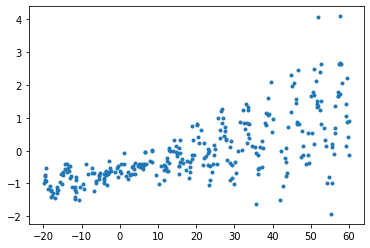

In [44]:

plt.plot(x,y,'.')
plt.show()

In [45]:
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

In [46]:
class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)

In [47]:

epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

In [48]:

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

In [49]:

m.eval()
y_estimate = m(X)

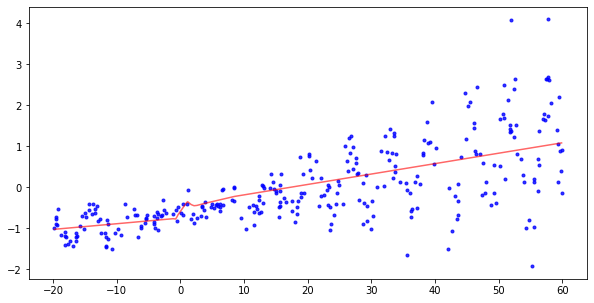

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(x,y, 'b.', alpha=0.8)
plt.plot(x, y_estimate.detach().numpy(), 'r', alpha=0.6)
plt.show()

In [51]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):        
        sigma = torch.exp(0.5 * log_var) + 1e-5
        epsilon = torch.randn_like(sigma)
        return mu + sigma * epsilon

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [53]:

def ll_gaussian(y, mu, log_var):   #log-likelihood of gaussian
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [54]:

def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

In [56]:

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [57]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

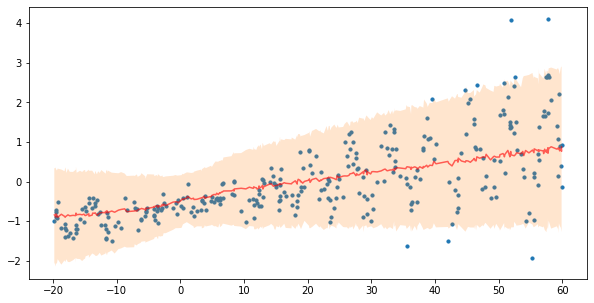

In [58]:

# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=10)
plt.plot(X, mu, 'r', alpha=0.6)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

In [60]:
#gaussian log likelihood
def det_loss2(y, y_pred, mu, log_var):   
  reconstruction_error = (0.5 * (y - y_pred)**2).sum()
  kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))

  return (reconstruction_error + kl_divergence).sum()

In [62]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss2(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

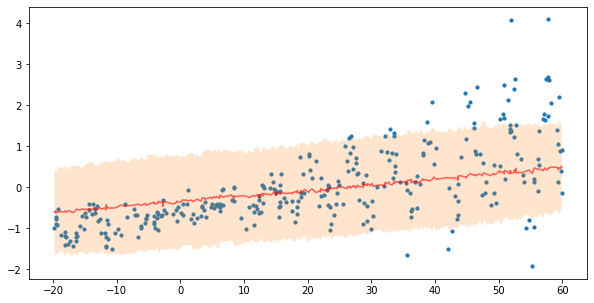

In [63]:

# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=10)
plt.plot(X, mu, 'r', alpha=0.6)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)